In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame = True)
data, target = housing.data, housing.target

In [2]:
# dataset description

print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
# first few rows of dataset

data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
# to simplify future visualization, we transform the price from 100 (k$) to 1000 (k$) range

target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

In [5]:
# decision tree regressor

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [7]:
# use mean absolute error to learn potential generalization performance

from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


Since we trained the model on the entire dataset, we got 0 testing error. However, our goal is to minimize generalization error or testing error. To get estimates of testing error, we need to have unseen data to test our model on. We need to split our dataset.

In [8]:
# split dataset

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state = 0
)

In [9]:
# fit model

regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

In [10]:
# estimate training error

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of out model is {score:.2f} k$")

The training error of out model is 0.00 k$


In [11]:
# estimate testing error

target_predicted = regressor. predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.31 k$


This testing error is what we would expect from our model in a production environment. However, when we do a single train-test split, we do not know if our evaluation is robust. Under certain conditions, this estimate of the testing error could be unstable and not reflect the 'true' error rate. Cross-validation allows for estimating the robustness of a predictive model because is repeats the splitting procedure.

In [12]:
# shuffle split cross-validation

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits = 40, test_size = 0.3, random_state = 0)
cv_results = cross_validate(
    regressor, data, target, cv = cv, scoring = "neg_mean_absolute_error"
)

In [13]:
# convert cv_results from Python dict to pandas df

import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.128698,0.001771,-46.840980
1,0.098395,0.001358,-46.941809
2,0.097270,0.001306,-47.251479
3,0.098043,0.001291,-44.183649
4,0.096158,0.001270,-47.494374


Cross_validate expects a score and score is a metric for which higher values mean better results while error is a metric where lower values mean better results. We transformed the error to a score in order to run cross_validate and we need to reverse this transformation to get the error.

In [14]:
# revert negation

cv_results["test_error"] = -cv_results["test_score"]

In [15]:
# check first 10 results

cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.128698,0.001771,-46.840980,46.840980
1,0.098395,0.001358,-46.941809,46.941809
2,0.097270,0.001306,-47.251479,47.251479
3,0.098043,0.001291,-44.183649,44.183649
4,0.096158,0.001270,-47.494374,47.494374
5,0.097496,0.001237,-45.945164,45.945164
6,0.098416,0.001314,-47.040937,47.040937
7,0.097550,0.001249,-45.914011,45.914011
8,0.099225,0.001348,-45.576302,45.576302
9,0.098832,0.001214,-45.690516,45.690516


In [16]:
# length of df corresponds to number of splits

len(cv_results)

40

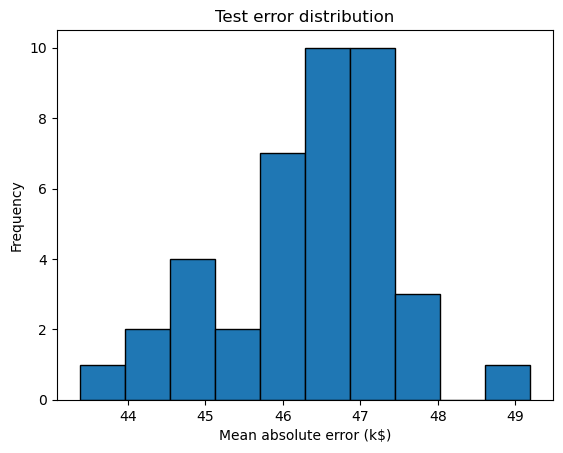

In [17]:
# plot test error distribution

import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins = 10, edgecolor = "black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

We observe that the testing error is clustered around 47 k\\$ and ranges from 43 k\\$ to 50 k\\$.

In [18]:
print(
    "The mean cross-validated testing error is: "
    f"{cv_results['test_error'].mean():.2f} k$"
)

The mean cross-validated testing error is: 46.35 k$


In [20]:
print(
    "The standard deviation of the testing error is: "
    f"{cv_results['test_error'].std():.2f} k$"
)

The standard deviation of the testing error is: 1.14 k$


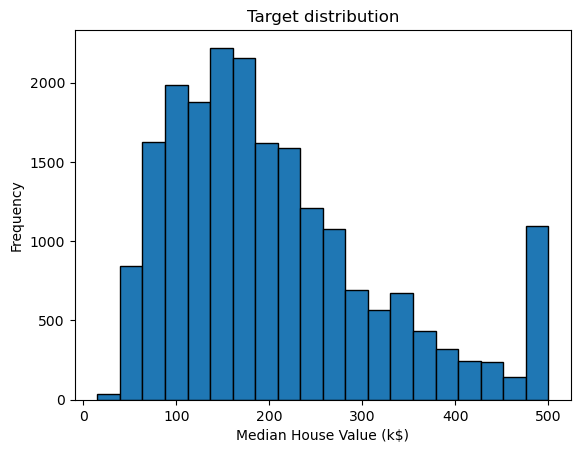

In [21]:
# to compare variability of testing error to natural variability of target

target.plot.hist(bins = 20, edgecolor = "black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [22]:
print(f"The standard deviation of the target is: {target.std():.2f} k")

The standard deviation of the target is: 115.40 k


Our testing error variability is smaller than the target variability which is generally good. However, because of the range of target, our error variability is only potentially viable at higher ranges of our target. At lower ranges of the target the error variability is too large indicating that our metric of mean absolute error is not ideal.

In [27]:
# obtain fitted models for each split/fold using return_estimator = True

cv_results = cross_validate(regressor, data, target, return_estimator = True)
cv_results

{'fit_time': array([0.14993691, 0.113554  , 0.11249399, 0.11336803, 0.11073208]),
 'score_time': array([0.00167489, 0.00081587, 0.000844  , 0.00077391, 0.00136805]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.27732469, 0.33848299, 0.39778592, 0.19071784, 0.41346361])}

In [24]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

In [26]:
# use cross_val_score when only interested in scores

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.27732469, 0.33848299, 0.39778592, 0.19071784, 0.41346361])